In [1]:
#%matplotlib notebook  
from matplotlib import pyplot as plt
import numpy as np
import db
import pasttrec_ctrl as ptc
import json
import sigproc_kit
import tdc_daq as td
import baseline_calib
import ROOT

from my_utils import *

def fwhm(x,y):
  dummy, t1, tot = sigproc_kit.discriminate(x,y,np.max(y)/2.,0,0)
  return tot

def hist_rms(x,y):
  counts = np.sum(y)
  weights = y / counts
  mean = np.dot(x,weights)
  deviations = x - mean
  return np.sqrt(  np.dot(deviations**2,weights)   )
def list_rms(x):
  mean = sum(x)/len(x)
  deviations = x - mean
  return np.sqrt(  sum(deviations**2) /len(x)  )
def list_mean(x):
  mean = sum(x)/len(x)
  return mean

Welcome to JupyROOT 6.14/04


['0110', '0030', '0029', '0027', '0026', '0025', '0023', '0022', '0021', '0020', '0018', '0017', '0016', '0015', '0014', '0011', '0010', '0009', '0007', '0004', '0003', '0002']


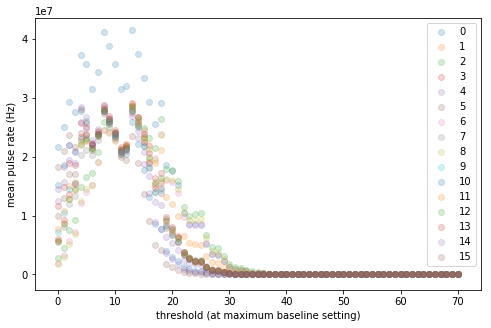

0110 average(16chan) noise thresh: mean =  10.845  +-  1.728   |  RMS  =  5.945  +-  0.558


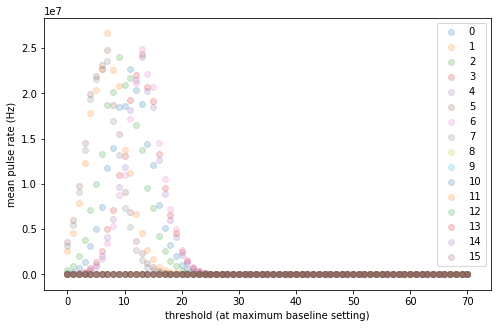

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


0030 average(16chan) noise thresh: mean =  nan  +-  nan   |  RMS  =  nan  +-  nan


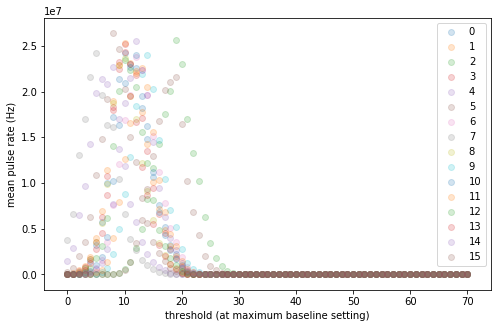

0029 average(16chan) noise thresh: mean =  11.709  +-  3.22   |  RMS  =  3.008  +-  0.174


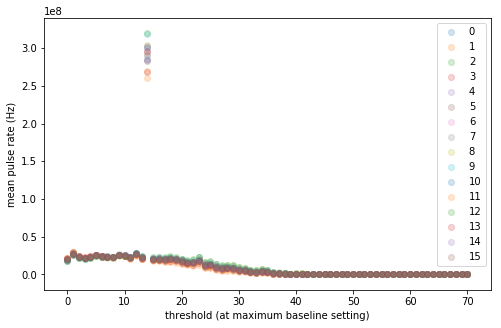

0027 average(16chan) noise thresh: mean =  13.726  +-  0.608   |  RMS  =  7.612  +-  0.286


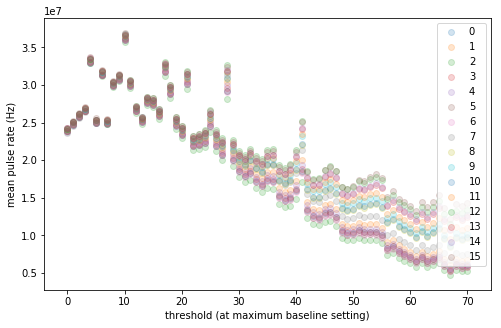

0026 average(16chan) noise thresh: mean =  27.365  +-  1.634   |  RMS  =  18.718  +-  0.674


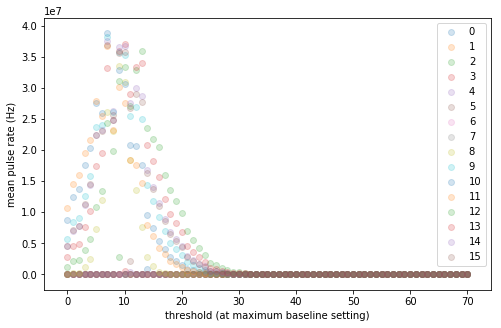

0025 average(16chan) noise thresh: mean =  nan  +-  nan   |  RMS  =  nan  +-  nan


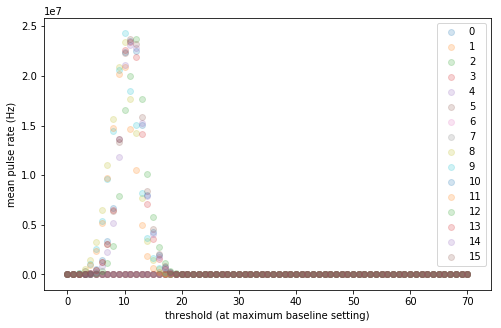

0023 average(16chan) noise thresh: mean =  nan  +-  nan   |  RMS  =  nan  +-  nan


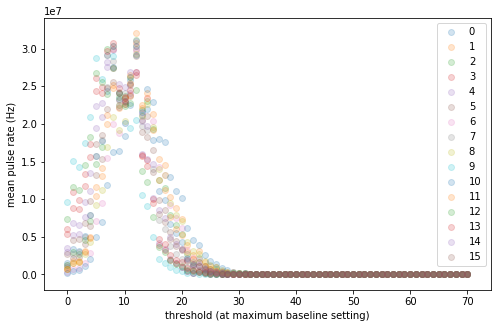

0022 average(16chan) noise thresh: mean =  10.397  +-  1.676   |  RMS  =  4.454  +-  0.269


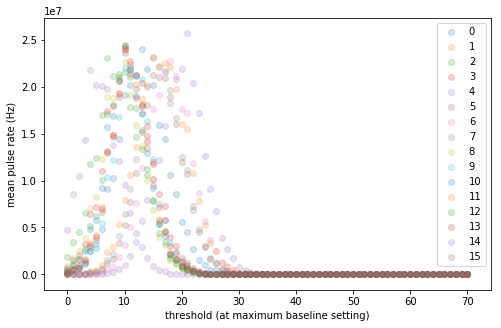

0021 average(16chan) noise thresh: mean =  12.524  +-  3.612   |  RMS  =  3.803  +-  0.297


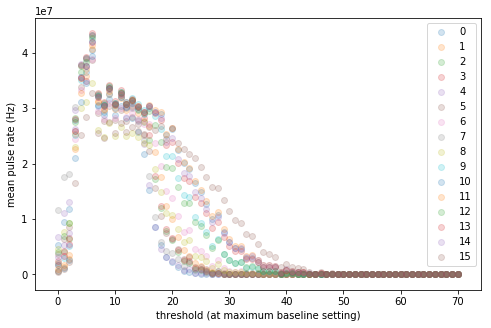

0020 average(16chan) noise thresh: mean =  11.868  +-  2.366   |  RMS  =  6.45  +-  1.452


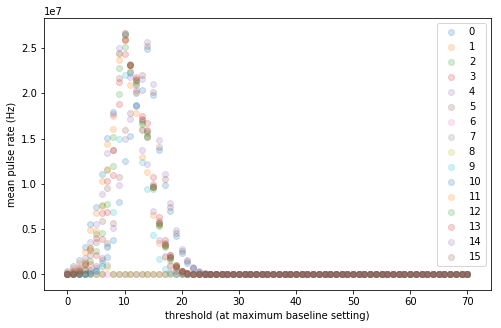

0018 average(16chan) noise thresh: mean =  11.171  +-  2.524   |  RMS  =  2.551  +-  1.116


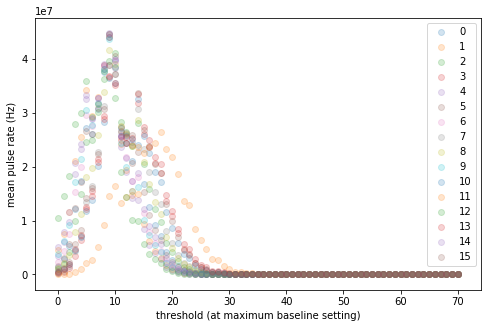

0017 average(16chan) noise thresh: mean =  10.516  +-  2.256   |  RMS  =  4.408  +-  0.411


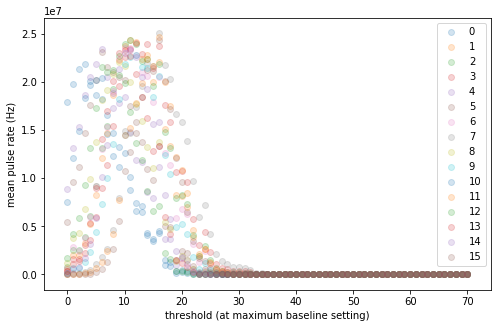

0016 average(16chan) noise thresh: mean =  11.207  +-  2.929   |  RMS  =  4.432  +-  0.51


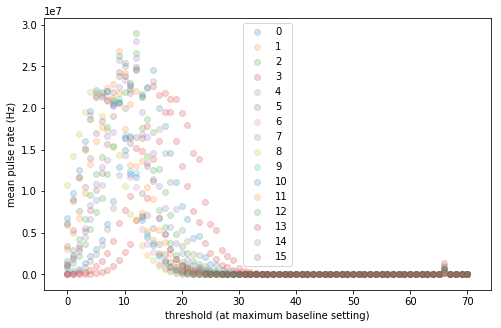

0015 average(16chan) noise thresh: mean =  10.58  +-  3.525   |  RMS  =  4.839  +-  0.479


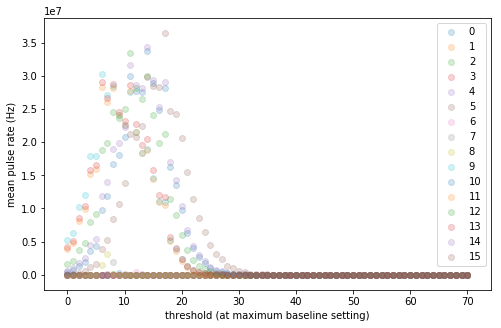

0014 average(16chan) noise thresh: mean =  10.579  +-  2.539   |  RMS  =  2.095  +-  2.191


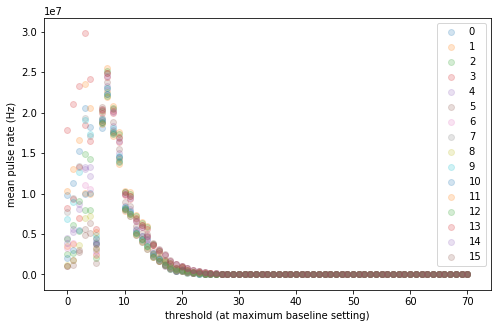

0011 average(16chan) noise thresh: mean =  7.432  +-  0.849   |  RMS  =  4.142  +-  0.277


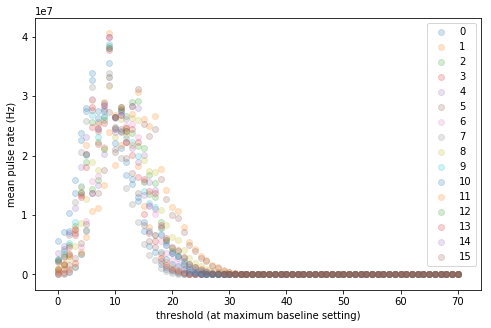

0010 average(16chan) noise thresh: mean =  10.53  +-  1.686   |  RMS  =  4.328  +-  0.549


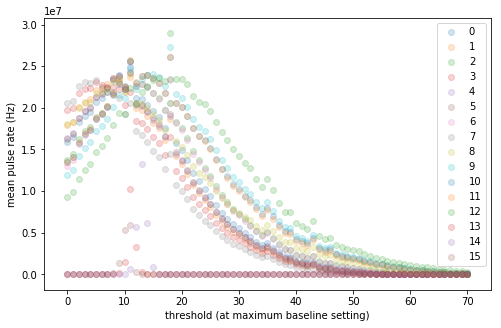

0009 average(16chan) noise thresh: mean =  15.133  +-  3.022   |  RMS  =  9.105  +-  4.184


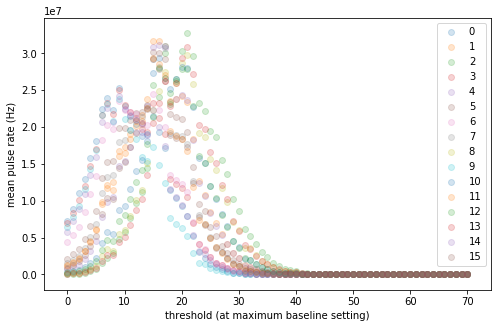

0007 average(16chan) noise thresh: mean =  15.364  +-  3.311   |  RMS  =  5.933  +-  0.137


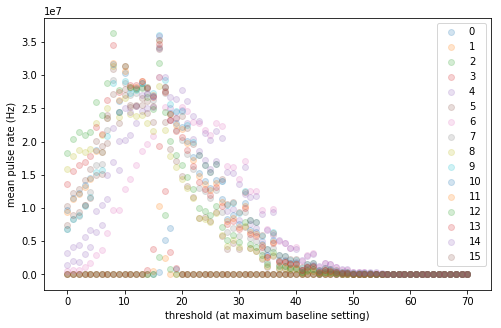

0004 average(16chan) noise thresh: mean =  16.5  +-  2.25   |  RMS  =  6.872  +-  3.608


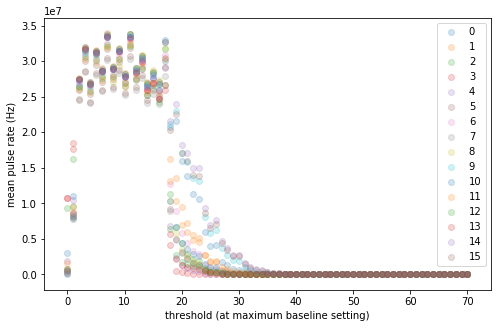

0003 average(16chan) noise thresh: mean =  10.385  +-  1.124   |  RMS  =  5.649  +-  0.723


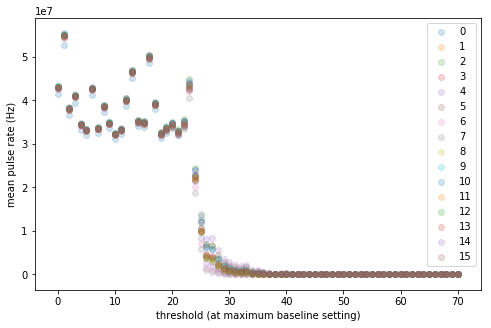

0002 average(16chan) noise thresh: mean =  11.967  +-  0.232   |  RMS  =  7.586  +-  0.195


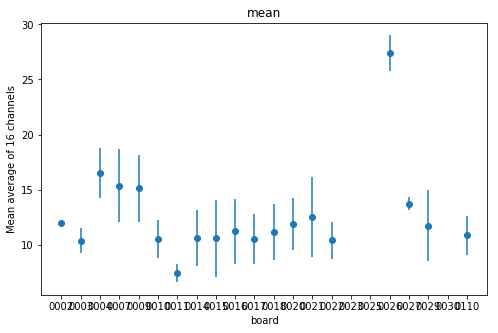

No handles with labels found to put in legend.


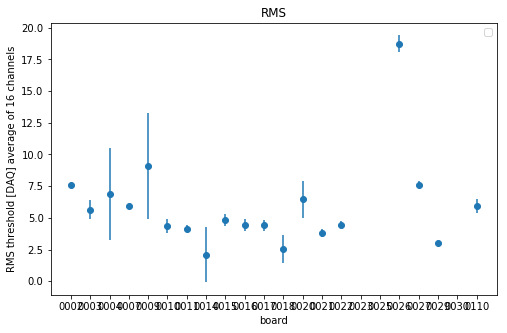

>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reached
>WARNING: Status-Bit(s) have been set:
>WARNING: CommonStatusBits: 0x0000, Channel#3 StatusBits: 0x0000
>WARNING:    COM_EndpointReached: no endpoint has been reache

In [2]:
## scan threshold of all boar
from functools import (reduce)
from math import (sqrt)
import numpy as np
import time
import tdc_daq as td

# rootMeanSquare :: [Num] -> Float
def rootMeanSquare(xs):
    return sqrt(reduce(lambda a, x: a + x * x, xs, 0) / len(xs))
def MeanArrays(xs,ys):
    return np.dot(xs,ys)/sum(ys)
import matplotlib.pyplot as plt

#used_boards = [ "0005", "0017", "0014", "0025" ]
# used_boards =  ['0010', '0101', '0102', '0103', '0104', '0105', '0106', '0108', '0020', '0005']
used_boards = db.board_list_installed()
used_boards = sorted(used_boards,key=str.lower, reverse=True)
print(used_boards)

plt.rcParams["figure.figsize"] = (8,5)
trendtime_list = []
rmsAverageTrend_list = []
rmsAverageTrendError_list = []
meanAverageTrend_list = []
meanAverageTrendError_list = []

for name in used_boards:

    board_info = db.find_board_by_name(name)
    if  board_info["tdc_addr"] == "0xeeef" or board_info["tdc_addr"] == "0xeeed":
    #if name == "0013" or name == "0018" or name == "0015" or name == "0006" or name == "0021" or name == "0028":
      continue
    ib = 0
    for my_board in db.board_list():
        db.set_standby_board(my_board)
#       ib += 1
#       if  ib > 0.5*len(db.board_list()):
#             break
    db.unset_standby_board(name)
    td.enable_tdc_channels_of_active_boards()
    ptc.init_active_boards()
    td.scaler_rate_of_board(name,0.2)
    #time.sleep(60)
    trendtime_list += [ name ]
    baselines_set =  [15] * 16 
    baseline_calib.set_baselines_individual(name,baselines_set)
    baseline_calib.char_noise_by_thresh_scan(name,dummy_calib=True)
    calib       = db.get_calib_json_by_name(name)
    dummy_calib = db.get_calib_json_by_name(name,dummy_calib=True)
    board_info  = db.find_board_by_name(name)

    #print(json.dumps(dummy_calib,indent=2, sort_keys=True))
    tsbl_scan_raw = dummy_calib["tsbl_scan_raw"]
    tsbl_range    = dummy_calib["tsbl_range"]

    

    for i in range(0,16):
     plt.scatter(tsbl_range,tsbl_scan_raw[i],alpha=0.2,label = "{:d}".format(i))

    plt.legend()
    plt.xlabel("threshold (at maximum baseline setting)")
    plt.ylabel("mean pulse rate (Hz)")
    #plt.yscale('log') 
    plt.show()

    fwhm_list = []
    max_list  = []
    rms_list = []
    mean_list = []
    for i in range(0,16):
      fwhm_list += [ fwhm(tsbl_range,tsbl_scan_raw[i]) ]
      rms_list += [ hist_rms(tsbl_range,tsbl_scan_raw[i]) ]
      mean_list += [ MeanArrays(tsbl_range,tsbl_scan_raw[i]) ]  
      max_list  += [ np.max(tsbl_scan_raw[i])  ]


    fwhm_list = np.array(fwhm_list)
    max_list  = np.array(max_list)
    
    print(name, "average(16chan) noise thresh: mean = ", round(sum(mean_list)/len(mean_list),3), " +- ", round(list_rms(mean_list),3), "  |  RMS  = ", round(sum(rms_list)/len(rms_list),3), " +- ", round(list_rms(rms_list),3) )

    meanAverageTrend_list += [ sum(mean_list)/len(mean_list) ]
    meanAverageTrendError_list += [ list_rms(mean_list) ]
    rmsAverageTrend_list += [ sum(rms_list)/len(rms_list) ]
    rmsAverageTrendError_list += [ list_rms(rms_list) ]    
    
    #plt.scatter(list(range(0,16)), mean_list)
    #plt.xlabel("channel no")
    #plt.ylabel("mean")
    #plt.show()
    #plt.scatter(list(range(0,16)), rms_list)
   # plt.xlabel("channel no")
    #plt.ylabel("RMS")
   # plt.title("noise width (RMS)")
  #  plt.show()

plt.errorbar(trendtime_list, meanAverageTrend_list, yerr=meanAverageTrendError_list, fmt='o')
#plt.scatter(trendtime_list, meanAverageTrend_list)
plt.xlabel("board")
plt.ylabel("Mean average of 16 channels")
plt.title("mean")
plt.show()
    
plt.errorbar(trendtime_list, rmsAverageTrend_list, yerr=rmsAverageTrendError_list, fmt='o')
plt.xlabel("board")
plt.ylabel("RMS threshold [DAQ] average of 16 channels")
plt.title("RMS")
plt.legend()
plt.show()
    #plt.scatter(list(range(0,16)), max_list)
    #plt.xlabel("channel no")
    #plt.ylabel("scaler rate")
    #plt.title("Max noise rate")
    #plt.show()

Mean (of all boards) =  nan  +-  nan
RMS (of all boards) =  nan  +-  nan


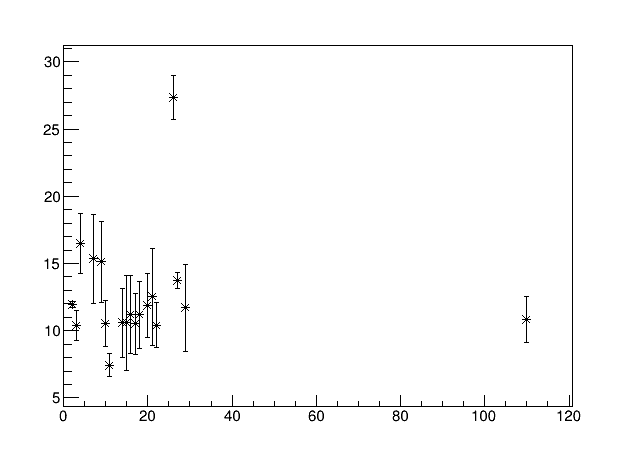

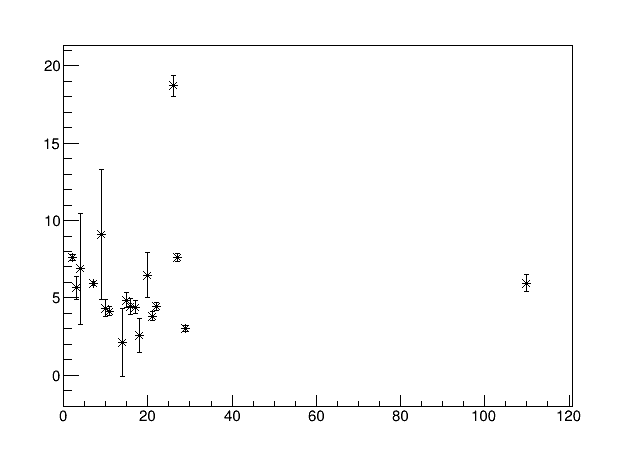

In [3]:
import ROOT


gr  = ROOT.TGraphErrors()
gr2 = ROOT.TGraphErrors()
#len(meanAverageTrend_list),np.array(trendtime_list),np.array(meanAverageTrend_list))
for i in range(0,len(meanAverageTrend_list)):
    gr.SetPoint(i, np.double(trendtime_list[i]), np.double(meanAverageTrend_list[i]))
    gr.SetPointError(i, 0, np.double(meanAverageTrendError_list[i]) )
    gr2.SetPoint(i, np.double(trendtime_list[i]), np.double(rmsAverageTrend_list[i]))
    gr2.SetPointError(i, 0, np.double(rmsAverageTrendError_list[i]) )    
c = ROOT.TCanvas("mean","mean",640,480)
gr.Draw("A*")
c.Draw()
c2 = ROOT.TCanvas("rms","rms",640,480)
gr2.Draw("A*")

c2.Draw()
print("Mean (of all boards) = ", list_mean(meanAverageTrend_list), " +- ", list_rms(meanAverageTrend_list) )
print("RMS (of all boards) = ", list_mean(rmsAverageTrend_list), " +- ", list_rms(rmsAverageTrend_list) )

#db.find_board_by_name("0030")

In [4]:
#db.find_board_by_tdc_connector("0x1503",2) # TDC as string, Connector as integer

In [5]:
#print("active board list (boards being programmed)")
#print(db.active_board_list())
#print("")
#print("complete board list (all boards in the database)")
#print(db.board_list())

In [6]:
#archive(label="my_important_thing")

In [7]:
#print("Hello World")